## Tutorial on OT for evaluating spatiotemporal predictions

What is the goal?
* Evaluate and compare ML models for geospatial prediction tasks
* Assess their *spatial* goodness - measuring how well their predictions match the spatial distribution of the ground truth (standard metrics

How does it work?
* The difference between the spatial distribution of the ground truth observations and the predicted spatial distribution is measured using Optimal Transport, i.e., the **Wasserstein Distance** or Earth Mover's Distance (EMD)
* For a simple explanation, check out the [EMD between signatures](https://en.wikipedia.org/wiki/Earth_mover%27s_distance#EMD_between_signatures). Our method is based on *discrete* OT, where the *sample points* are spatial locations and the *mass* at these points are the observations or predictions. OT finds the *minimal cost transportation matrix*, i.e. the mass that must be transported between each pair of locations to align the predicted with the observed distribution.
* In practice, we provide an interface to other OT python packages for the specific use case on geospatial data. Here, the input is usually just the `observations` at a set of location, the `predictions` and the `cost matrix`. The output is the OT error (a single number) or the optimal transport matrix T.
* Apart from evaluation, OT can be leveraged as a loss function using the Sinkhorn loss.


How to use your own data?
* This tutorial simulates predictions using random values. You can adapt the code to use your own data by replacing the variables `locations`, `observations`, `predictions` and `cost_matrix`.
* Note on negative values: OT can only be computed between two arrays of positive values (or 0). However, if your observations are negative, you can simply scale them (e.g. `values = values + np.min(values)`). The OT error is meaningful in that case, because its value depends on the *residuals* and not the absolute values.
* Custom cost matrices: This tutorial uses Euclidian distances as the cost matrix. However, the cost matrix can be really anything - monetary costs, travel times, map-matched distances, etc. Simply replace `cdist` in this tutorial by your function to compute the pairwise distances between locations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from geot.partialot import PartialOT, partial_ot_paired, partial_ot_unpaired
from geot.plotting import plot_cost_matrix, plot_predictions_and_ground_truth, plot_unpaired_transport_matrix, plot_paired_transport_matrix

## Part 1: OT error for evaluating predictions at fixed locations

#### Sample data

Let's create some synthetic observations and predictions. We sample the predictions as normally distributed around the true observations.

In [2]:
NUM_LOCS = 100

In [6]:
# sample x and y coordinates for NUM_LOCS locations
locations = np.random.rand(NUM_LOCS, 2)
# sample observations at these locations
observations = np.random.normal(size=NUM_LOCS, loc=20, scale=3)
# sample predictions -> add noise to observations
predictions = np.random.normal(size=NUM_LOCS, loc=observations, scale=3)
print("Sampled data", locations.shape, observations.shape, predictions.shape)

Sampled data (100, 2) (100,) (100,)


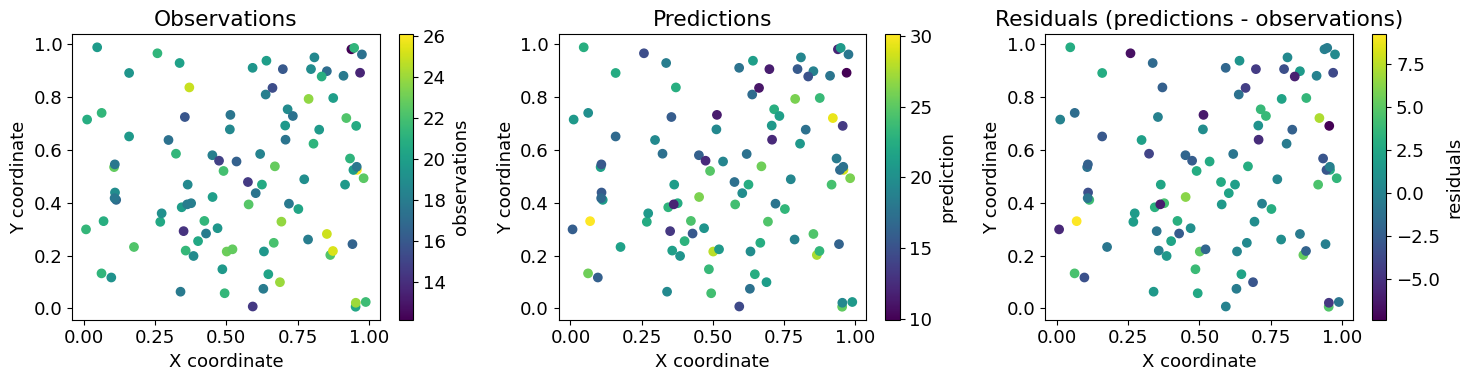

In [4]:
plot_predictions_and_ground_truth(locations, predictions, observations)

#### Set cost matrix

To compute the spatial prediction error, we first require a cost matrix. As a simple example, we compute the Euclidean distances between locations.

C is a 2D matrix of shape (100, 100)


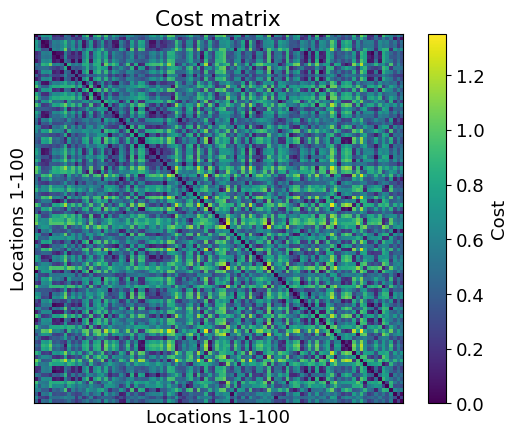

In [7]:
# compute pairwise costs
cost_matrix = cdist(locations, locations)
print("C is a 2D matrix of shape", cost_matrix.shape)

# plot matrix
plot_cost_matrix(cost_matrix)

#### Computing the Optimal Transport error

We initialize a PartialOT object. One parameter we need to set is `penalty_waste`, i.e. how much to penalize the overall difference between observations and predictions, i.e. between `sum(observations)` and `sum(predictions)`. Here, we set it to zero since we are only interested in the spatial errors (the transport costs to align predictions and ground truth).

In [8]:
ot_computer = PartialOT(cost_matrix, penalty_waste=0)

In [9]:
ot_error = ot_computer(predictions, observations)
print("The OT error is", ot_error)

The OT error is 21.90970489098093


There is also a function available that does everything at ones:

In [13]:
partial_ot_paired(cost_matrix, predictions, observations, penalty_waste=0)

21.90970489098093

#### Investigating the Optimal Transport matrix

To gain more insight into the error distribution, we can also look at the optimal transport matrix T*. Note that the diagonal has high values since most predicted mass corresponds at least partly to the ground truth mass and does not need to be transported. The mass that needs to be transported - due to errors - is visible outside the diagonal.

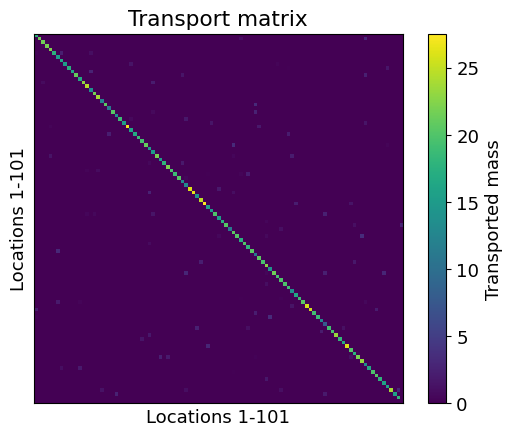

In [10]:
transport_matrix = partial_ot_paired(cost_matrix, predictions, observations, penalty_waste=0, return_matrix=True)
plot_cost_matrix(transport_matrix, title="Transport matrix", label="Transported mass")

The Frobenius norm (the sum of the element-wise product between transport matrix and cost matrix) corresponds to the OT error:

In [12]:
print("The Frobenius norm of the transport matrix and the costs: ", 
      np.sum(transport_matrix[:-1, :-1] * cost_matrix) # note: transport_matrix has shape (N+1, N+1) due to the waste vector
     )

The Frobenius norm of the transport matrix and the costs:  21.90970489098093


The transport matrix indicates where the mass must be transported to align both distributions. In the geospatial evaluation framework, it shows how errors are accounted for. We can plot the residuals and display the transport matrix as arrows, showing how transport of mass occurs between neighboring locations, where the observations of one are overestimated and of the other one underestimated.

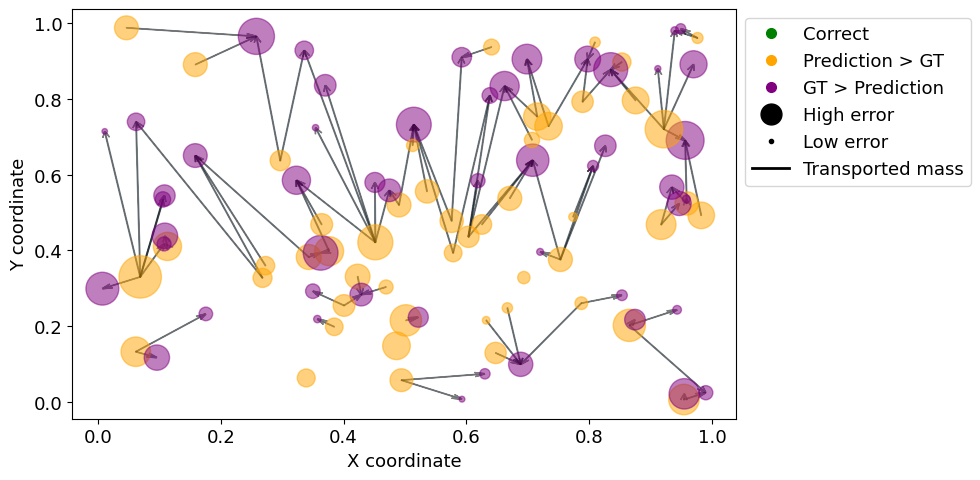

In [10]:
# Plot transport of mass
plot_paired_transport_matrix(
    locations, predictions, observations, transport_matrix
)

## Part 2: OT error for evaluating unpaired predictions and gt (location prediction)

So far, we have assumed a use case with *paired* data, i.e., the locations are fixed and there is always one observation and one prediction per location. However, some use cases in GeoAI require to predict the *locations*, e.g. predicting where some event occurs. For instance, imagine that someone aims to predict the locations of crimes over the next months. In that case, there is a set of locations where crimes actually occur, and a set of locations where they were predicted to occur. These sets are unpaired, i.e., there is no way to make pairwise matches between observed and predicted locations.

Let's create some synthetic data again for demonstration purposes:

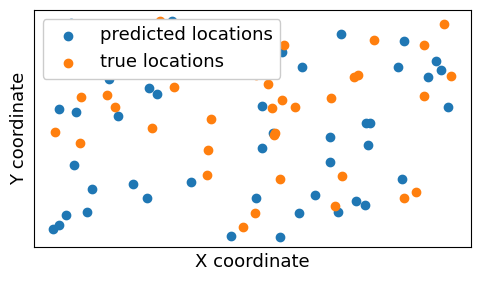

In [11]:
predicted_locations = np.random.rand(50, 2)
true_locations = np.random.rand(40, 2)

# this function is meant to plot the OT matrix. Here, we set the matrix to zeros to just plot the locations
plot_unpaired_transport_matrix(
    predicted_locations, true_locations, np.zeros((50, 40))
)

The function `partial_ot_unpaired` allows to compute the OT error for these predictions:

In [12]:
# Compute OT error, setting
ot_error = partial_ot_unpaired(
    predicted_locations, true_locations, cost_matrix=None, import_location=np.array([0, 0]), penalty_waste=0, return_matrix=False
)
print("OT error for predictions", ot_error)

OT error for predictions 0.07292945378633789


Again, we can plot the optimal transport matrix that indicates between which locations mass has to be transported:

In [13]:
# Execute function again, this time with return_matrix=True
transport_matrix = partial_ot_unpaired(
    predicted_locations, true_locations, cost_matrix=None, import_location=np.array([0, 0]), penalty_waste=0, return_matrix=True
)

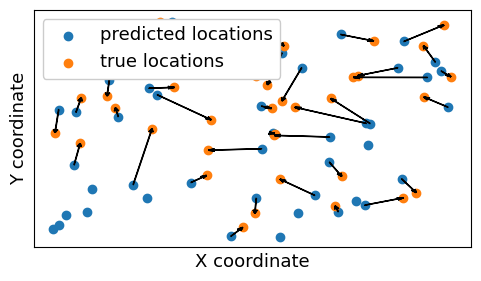

In [14]:
# Plot the transport matrix
plot_unpaired_transport_matrix(
    predicted_locations, true_locations, transport_matrix
)

## Part 3: OT as a loss function

In addition to using OT as an evaluation framework, we can also use it for *training* as a loss function.

The following example is adapted from https://unit8co.github.io/darts/generated_api/darts.models.forecasting.nhits.html. We will use a standard Time Series Forecasting model, N-HiTS, to predict tourism in Australia.

To run the example, you first need to install the `darts` library.

In [15]:
# !pip install darts

#### Defining a cost matrix based on a spatial dataset 

We use a spatiotemporal dataset from `darts`: Tourism in Australia by region. As the cost matrix, we set the cost=1 between regions that are neighbors and cost=2 for regions that are no neighbors (see definition below).

In [16]:
from darts.datasets import AustralianTourismDataset

series = AustralianTourismDataset().load()
# We only include holiday visitors
include_cols = ["NSW - hol", "VIC - hol", "QLD - hol", "SA - hol", "WA - hol", "TAS - hol", "NT - hol"]
to_be_dropped = [col for col in list(series.components) if col not in include_cols]
series = series.drop_columns(to_be_dropped)
print("This time series has 7 components:")
print(series.components)

This time series has 7 components:
Index(['NSW - hol', 'VIC - hol', 'QLD - hol', 'SA - hol', 'WA - hol',
       'TAS - hol', 'NT - hol'],
      dtype='object', name='component')


In [17]:
def make_australia_cost_matrix():
    # [“NSW”, “VIC”, “QLD”, “SA”, “WA”, “TAS”, “NT”]
    
    # Initialize a 7x7 matrix with all elements as 2 (non-neighbors)
    cost_matrix = np.full((7, 7), 2)
    
    # Set diagonal to 0
    np.fill_diagonal(cost_matrix, 0)
    
    # Define the neighbors
    neighbors = {
        0: [1, 2, 3],  # NSW neighbors VIC, QLD, SA
        1: [0, 3],     # VIC neighbors NSW, SA
        2: [0, 3, 6],     # QLD neighbors NSW, NT, SA
        3: [0, 1, 2, 4, 6],  # SA neighbors NSW, VIC, QLD, WA, NT
        4: [3, 6],     # WA neighbors SA, NT
        5: [],         # TAS has no neighbors
        6: [2, 3, 4]   # NT neighbors QLD, SA, WA
    }
    
    # Set cost to 1 for neighbors
    for state, neighs in neighbors.items():
        for neigh in neighs:
            cost_matrix[state, neigh] = 1
            cost_matrix[neigh, state] = 1  # Since the matrix is symmetric
    
    # Display the result
    return cost_matrix
australia_cost_matrix = make_australia_cost_matrix()
print("The pairwise costs are defined such that neighboring states have lower cost:")
australia_cost_matrix

The pairwise costs are defined such that neighboring states have lower cost:


array([[0, 1, 1, 1, 2, 2, 2],
       [1, 0, 2, 1, 2, 2, 2],
       [1, 2, 0, 1, 2, 2, 1],
       [1, 1, 1, 0, 1, 2, 1],
       [2, 2, 2, 1, 0, 2, 1],
       [2, 2, 2, 2, 2, 0, 2],
       [2, 2, 1, 1, 1, 2, 0]])

#### Defining the Sinkhorn loss

In [18]:
# IMPORTANT: Set entropy_regularized=True to use the differentiable Sinkhorn loss instead of standard EMD
sinkhorn_loss = PartialOT(australia_cost_matrix, entropy_regularized=True)

#### Training the model

In [19]:
from darts.models import NHiTSModel

model = NHiTSModel(
    input_chunk_length=6,
    output_chunk_length=6,
    num_blocks=2,
    n_epochs=5,
    loss_fn=sinkhorn_loss # ADDING LOSS FUNCITON HERE
)
model.fit(series[:100])
pred = model.predict(6)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | train_metrics | MetricCollection | 0     
1 | val_metrics   | MetricCollection | 0     
2 | stacks        | ModuleList       | 1.9 M 
---------------------------------------------------
1.9 M     Trainable params
21.5 K    Non-trainable params
1.9 M     Total params
7.522     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/Users/ninawiedemann/miniconda3/envs/gis/lib/python3.9/site-packages/torch/nn/functional.py:682: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool1d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

### Part 4: OT over space and time

We can also evaluate predictions over space and time. For instance, assume we predicted bike sharing demand for the next 5 hours, so we have the predictions for 5 timesteps and n locations. 

In [3]:
NUM_TIME = 5 # 5 time steps
# sample x and y coordinates for NUM_LOCS locations
locations = np.random.rand(NUM_LOCS, 2)
# sample observations at these locations
observations = np.random.normal(size=(NUM_TIME, NUM_LOCS), loc=20, scale=3)
# sample predictions -> add noise to observations
predictions = np.random.normal(size=(NUM_TIME, NUM_LOCS), loc=observations, scale=3)
print("Sampled data", locations.shape, observations.shape, predictions.shape)

Sampled data (100, 2) (5, 100) (5, 100)


We define a cost matrix from a user perspective that takes the maximum 
of the relocation time (time to walk to another station with bikes 
available) and the waiting time (time to wait until a bike becomes 
available at this station).

In [4]:
from geot.cost import space_cost_matrix, spacetime_cost_matrix

# create a normal 2D cost matrix where the costs corresond to relocation time, assuming a constant walking speed
time_matrix = space_cost_matrix(locations, speed_factor=5) # 5km/h walking speed
# create cost matrix with costs across space and time
spacetime_matrix = spacetime_cost_matrix(
    time_matrix,
    time_steps=5,
    forward_cost=1,
    backward_cost=1
)

In [5]:
time_matrix.shape, spacetime_matrix.shape

((100, 100), (500, 500))

Now the cost matrix has shape 500x500 since it maps from every space-time combination to another. 

Finally, we can apply OT when setting `spatiotemporal=True` in the PartialOT function:

In [6]:
ot_computer = PartialOT(spacetime_matrix, spatiotemporal=True, penalty_waste=0)
ot_error = ot_computer(observations, predictions)

In [7]:
ot_error

109.57049296916266